# Assignment 1 - Part 2

In [2]:
import zipfile
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from sklearn.metrics import roc_curve, auc
from itertools import cycle



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Pre-processing

In [3]:
path = 'part_2_cnn_dataset.zip'
path = '/content/drive/MyDrive/part_2_cnn_dataset.zip'


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
import zipfile
from torchvision.datasets import ImageFolder

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('dataset')
dataset = ImageFolder(root='dataset', transform=transforms.ToTensor())
print(f"no of images: {len(dataset)}")
print(f"shape of an image: {dataset[0][0].shape}")

no of images: 30000
shape of an image: torch.Size([3, 64, 64])


In [10]:
from torch.utils.data import random_split



train_size, val_size, test_size = int(0.7*len(dataset)), int(0.15*len(dataset)), int(0.15*len(dataset))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle = True)

In [11]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 21000
Validation dataset size: 4500
Test dataset size: 4500


### Visualizations

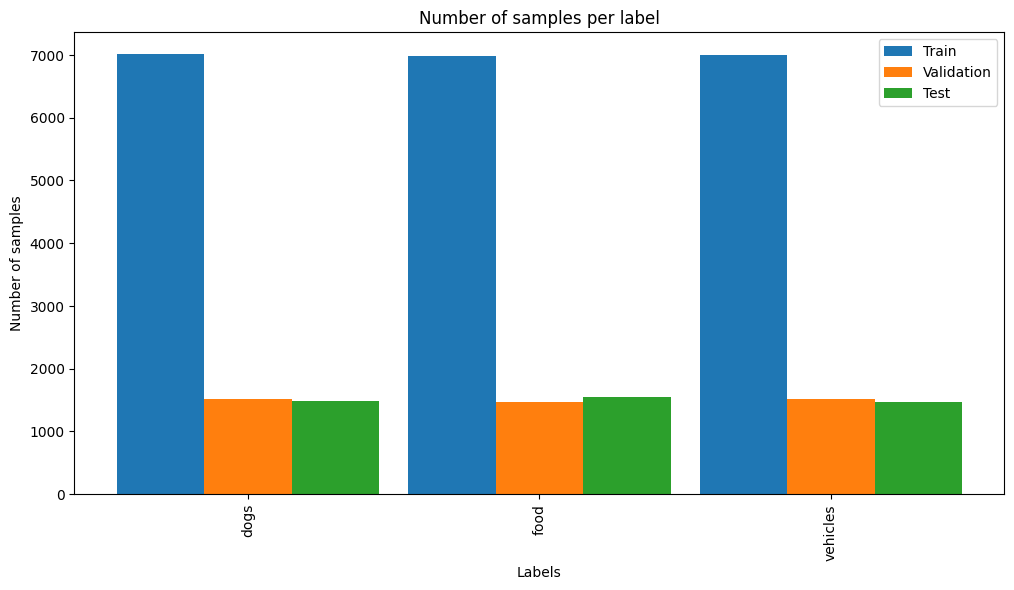

In [12]:
def count_samples_per_class(dataset):
    class_counts = np.zeros(len(dataset.dataset.classes))
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

train_counts = count_samples_per_class(train_dataset)
val_counts = count_samples_per_class(val_dataset)
test_counts = count_samples_per_class(test_dataset)

classes = dataset.classes
x = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.3
ax.bar(x - width, train_counts, width, label='Train')
ax.bar(x, val_counts, width, label='Validation')
ax.bar(x + width, test_counts, width, label='Test')

ax.set_xlabel('Labels')
ax.set_ylabel('Number of samples')
ax.set_title('Number of samples per label')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=90)
ax.legend()
plt.show()

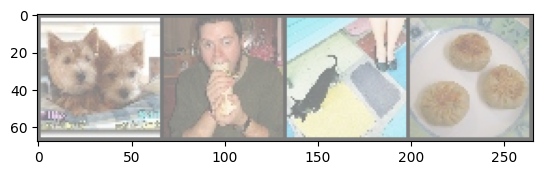

dogs food dogs food


In [13]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

### VGG 13 Version B

In [14]:
class VGG13Base(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13Base, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x,1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x

model = VGG13Base(num_classes=3).to(device)
print(model)


VGG13Base(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
train_accuracies = []
validation_accuracies = []
test_accuracies = []
train_losses = []
validation_losses = []
test_losses = []

epochs = 15

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total = labels.size(0)
        train_correct = (predicted == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * (train_correct / train_total))

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader)}")

    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            validation_total += labels.size(0)
            validation_correct += (predicted == labels).sum().item()
        validation_losses.append(validation_loss / len(validation_loader))
        validation_accuracies.append(100 * (validation_correct / validation_total))

    print(f"Validation Loss: {validation_loss / len(validation_loader)}, Accuracy: {100 * validation_correct / validation_total}%")

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * (test_correct / test_total))

print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * test_correct / test_total}%")


Epoch 1, Loss: 0.6700045324507213
Validation Loss: 0.6769938111305237, Accuracy: 87.88888888888889%
Epoch 2, Loss: 0.6629748003823417
Validation Loss: 0.6717268705368042, Accuracy: 88.15555555555555%
Epoch 3, Loss: 0.6561301293827239
Validation Loss: 0.670120108127594, Accuracy: 88.4888888888889%
Epoch 4, Loss: 0.6513268067723229
Validation Loss: 0.6621182322502136, Accuracy: 89.37777777777778%
Epoch 5, Loss: 0.6459476153055826
Validation Loss: 0.6661143898963928, Accuracy: 88.95555555555555%
Epoch 6, Loss: 0.642155579158238
Validation Loss: 0.659871518611908, Accuracy: 89.46666666666667%
Epoch 7, Loss: 0.6373766178176516
Validation Loss: 0.6920939445495605, Accuracy: 85.88888888888889%
Epoch 8, Loss: 0.6334777815001351
Validation Loss: 0.6546753644943237, Accuracy: 90.11111111111111%
Epoch 9, Loss: 0.6301710378556025
Validation Loss: 0.6576567888259888, Accuracy: 89.77777777777777%
Epoch 10, Loss: 0.6256505477996099
Validation Loss: 0.6592530369758606, Accuracy: 89.53333333333333%
Epo

In [19]:
path = '/content/drive/MyDrive/'
with open(path + 'akapoor5_sumandha_assignment1_part2_trained.pkl', 'wb') as file:
    pickle.dump(model, file)

### Performance of VGG 13 Version B

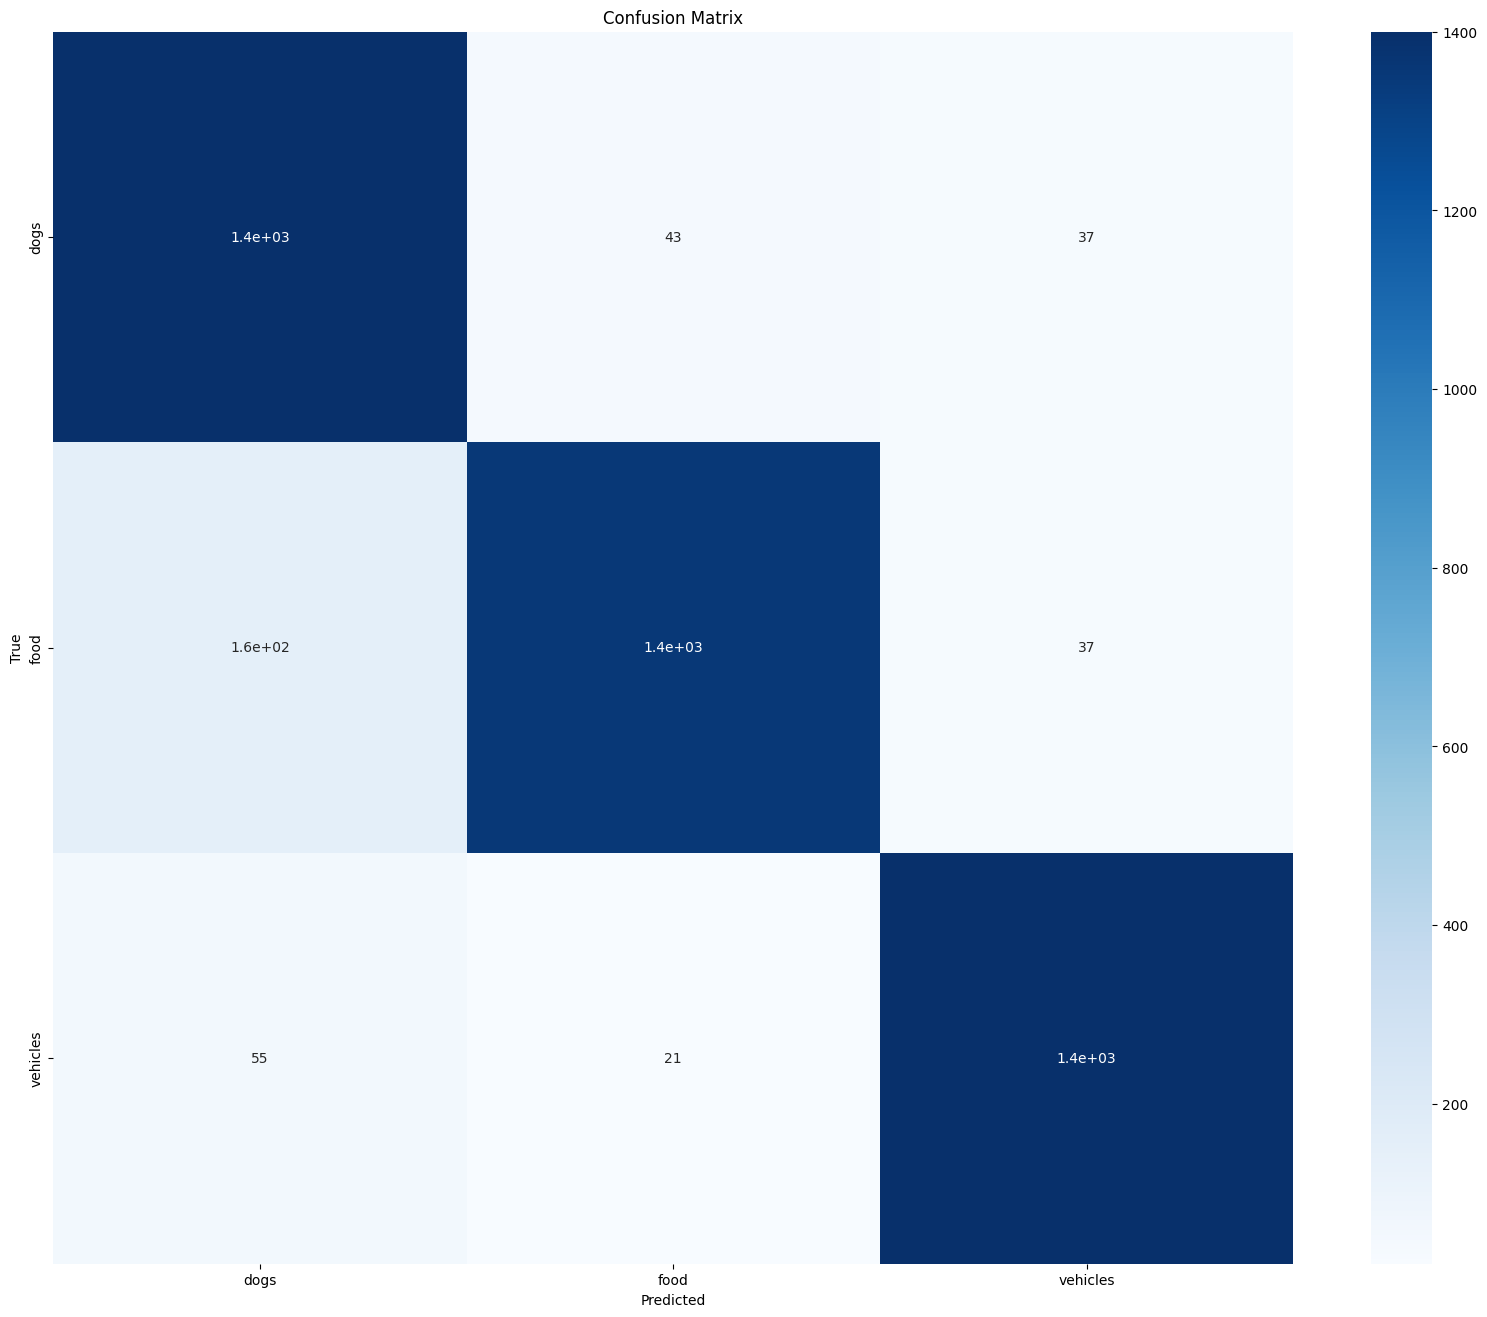

In [20]:
model.eval()
all_pred = []
all_label = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_pred.extend(preds.cpu().numpy())
        all_label.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_label, all_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

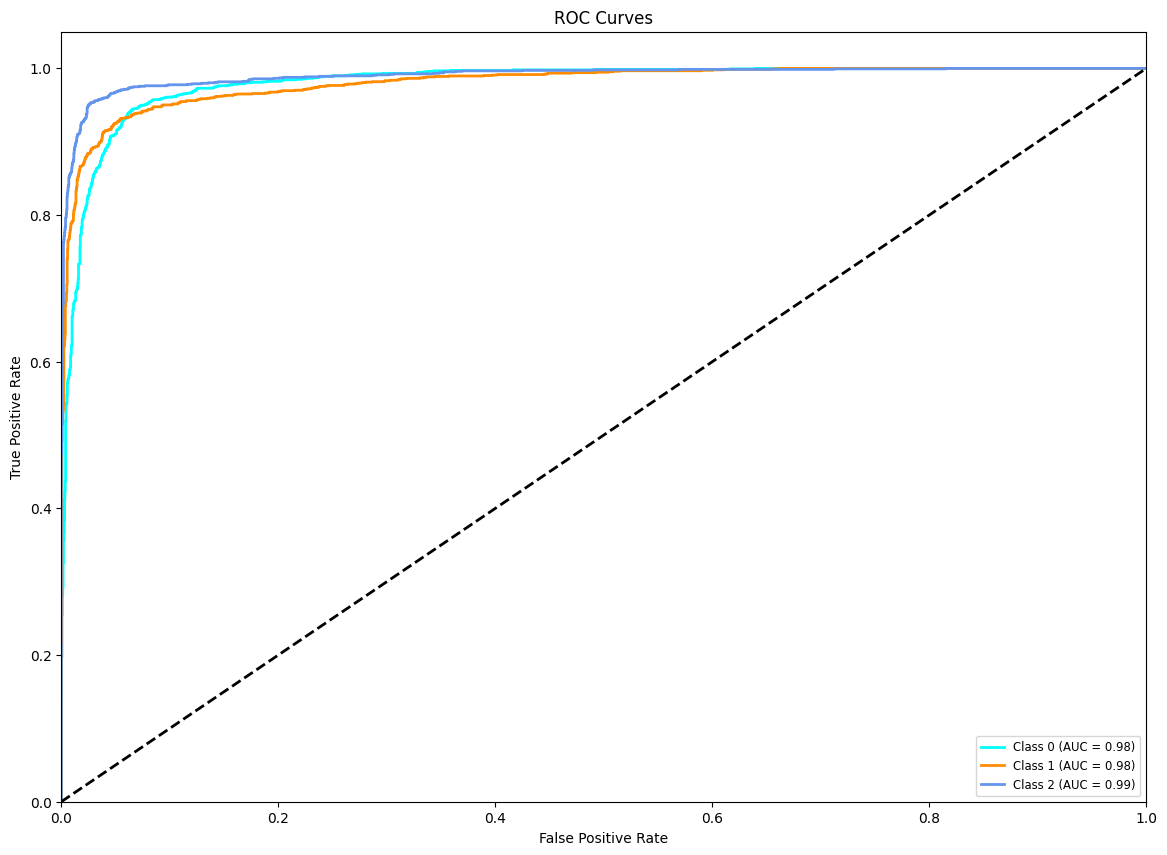

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.preprocessing import label_binarize

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

if len(all_labels.shape) == 1 or all_labels.shape[1] != 3:
    all_labels = label_binarize(all_labels, classes=range(3))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(14, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'yellow', 'purple', 'pink', 'brown'])

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right", fontsize='small')
plt.show()


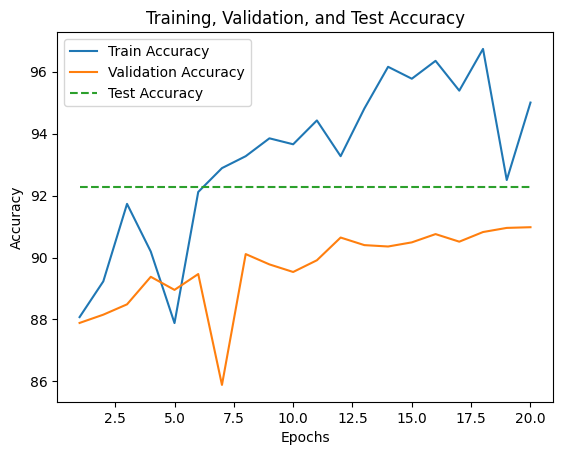

In [26]:
plt.figure()
epochs_range = range(1, len(train_accuracies) + 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, [test_accuracies[-1]] * len(epochs_range), label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


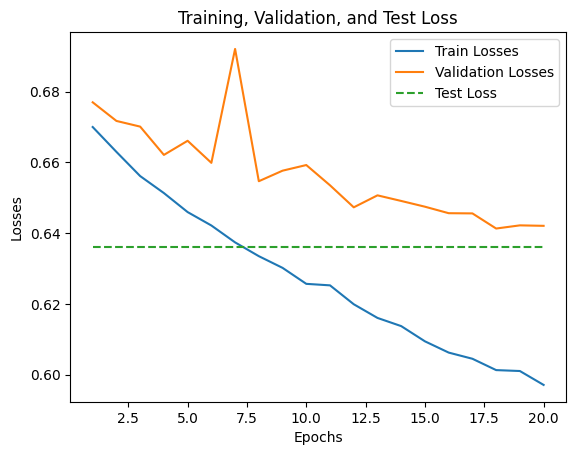

In [27]:
plt.figure()
epochs_range = range(1, len(train_accuracies) + 1)
plt.plot(epochs_range, train_losses, label='Train Losses')
plt.plot(epochs_range, validation_losses, label='Validation Losses')
plt.plot(epochs_range, [test_losses[-1]] * len(epochs_range), label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

### Adding L2 regularization to VGG13

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class VGG13Base(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13Base, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x,1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x

model = VGG13Base(num_classes=3).to(device)
print(model)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

VGG13Base(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [29]:
train_accuracies = []
validation_accuracies = []
test_accuracies = []
train_losses = []
validation_losses = []
test_losses = []

epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total = labels.size(0)
        train_correct = (predicted == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * (train_correct / train_total))

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader)}")

    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            validation_total += labels.size(0)
            validation_correct += (predicted == labels).sum().item()
        validation_losses.append(validation_loss / len(validation_loader))
        validation_accuracies.append(100 * (validation_correct / validation_total))

    print(f"Validation Loss: {validation_loss / len(validation_loader)}, Accuracy: {100 * validation_correct / validation_total}%")

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * (test_correct / test_total))

print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * test_correct / test_total}%")


Epoch 1, Loss: 1.0804120642798287
Validation Loss: 1.0987077236175538, Accuracy: 33.22222222222222%
Epoch 2, Loss: 1.0025421522912525
Validation Loss: 1.0681593656539916, Accuracy: 49.333333333333336%
Epoch 3, Loss: 0.8987351372128441
Validation Loss: 0.8703884363174439, Accuracy: 75.4%
Epoch 4, Loss: 0.8254648163205102
Validation Loss: 0.802050507068634, Accuracy: 78.46666666666667%
Epoch 5, Loss: 0.777586213179997
Validation Loss: 0.772382915019989, Accuracy: 80.55555555555556%
Epoch 6, Loss: 0.7464610025996253
Validation Loss: 0.7458345174789429, Accuracy: 81.97777777777777%
Epoch 7, Loss: 0.7249333347593035
Validation Loss: 0.72408607006073, Accuracy: 83.64444444444445%
Epoch 8, Loss: 0.7089627527055287
Validation Loss: 0.7145750999450684, Accuracy: 84.42222222222222%
Epoch 9, Loss: 0.6947923047201974
Validation Loss: 0.6973839282989502, Accuracy: 85.91111111111111%
Epoch 10, Loss: 0.6827845431509472
Validation Loss: 0.6905129790306092, Accuracy: 87.0%
Epoch 11, Loss: 0.67479767118

In [30]:
with open(path + 'akapoor5_sumandha_assignment1_part2_trained_l2.pkl', 'wb') as file:
    pickle.dump(model, file)

### Performance of VGG13 with regularization

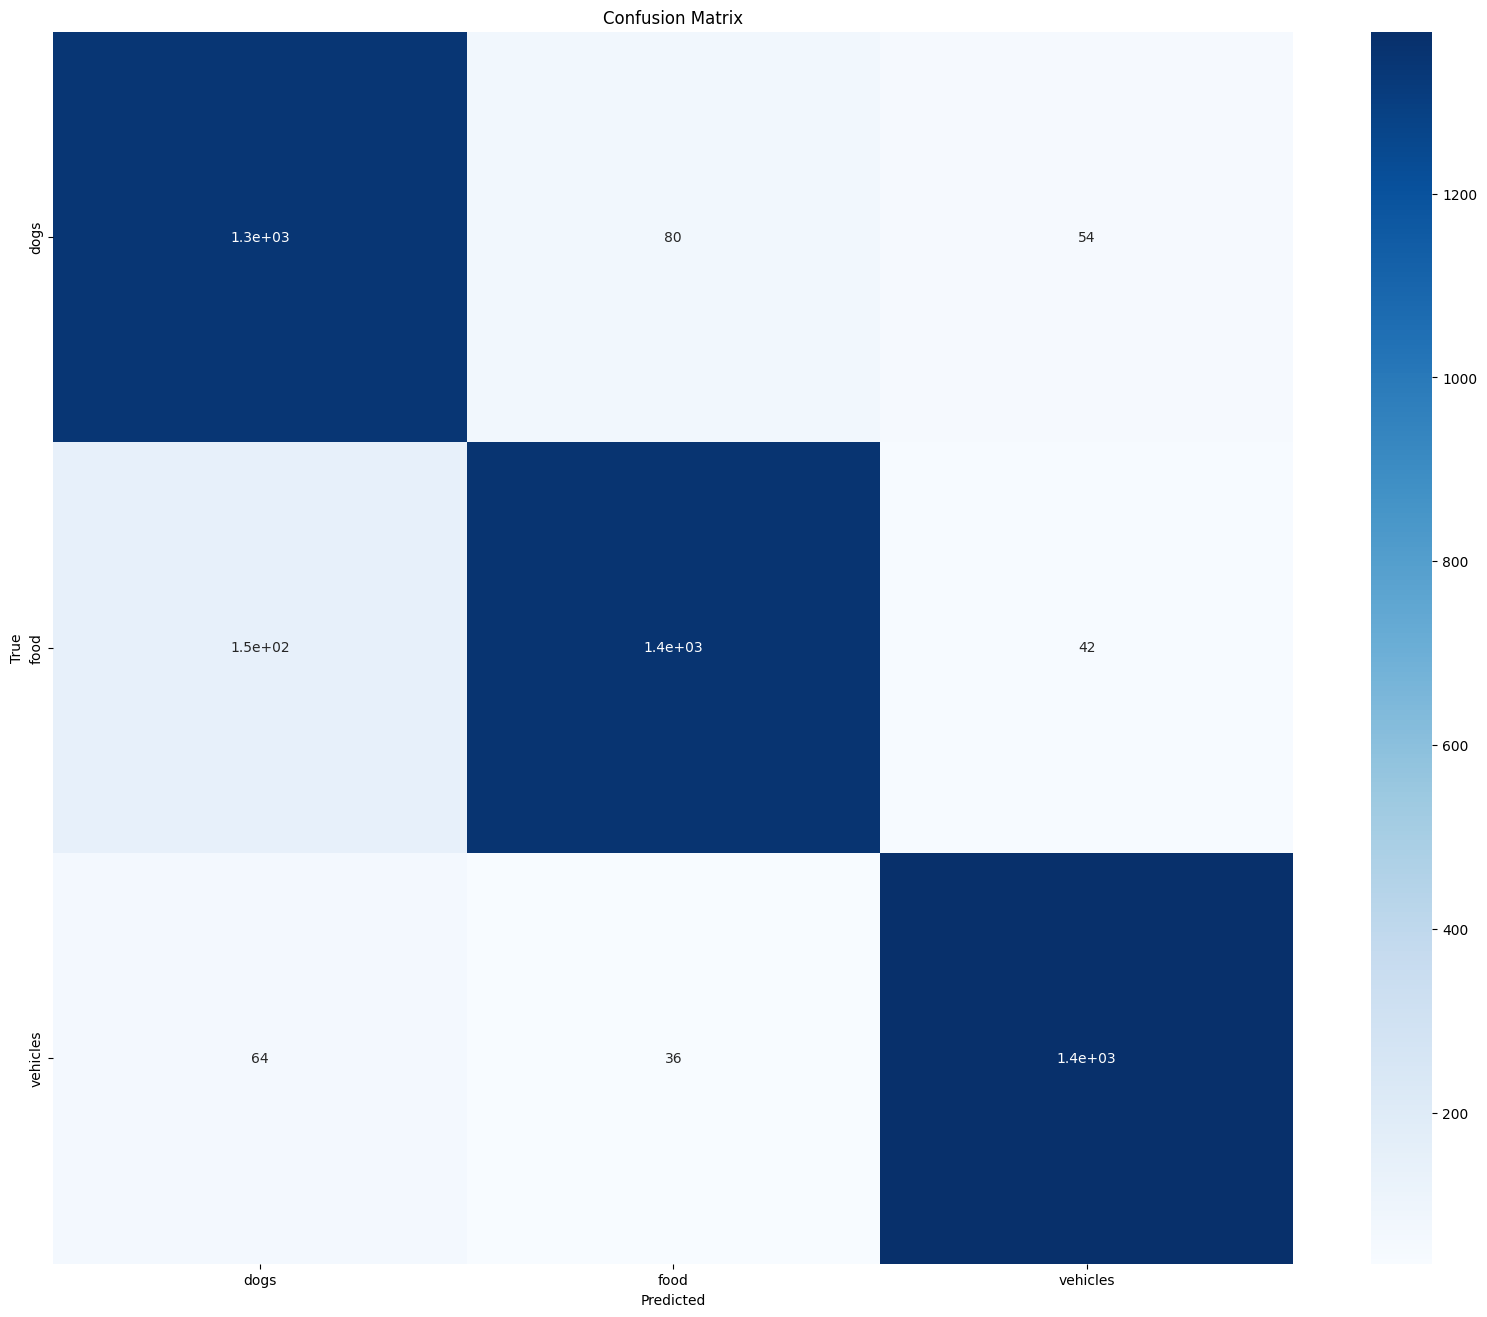

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.eval()
all_pred = []
all_label = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_pred.extend(preds.cpu().numpy())
        all_label.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_label, all_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

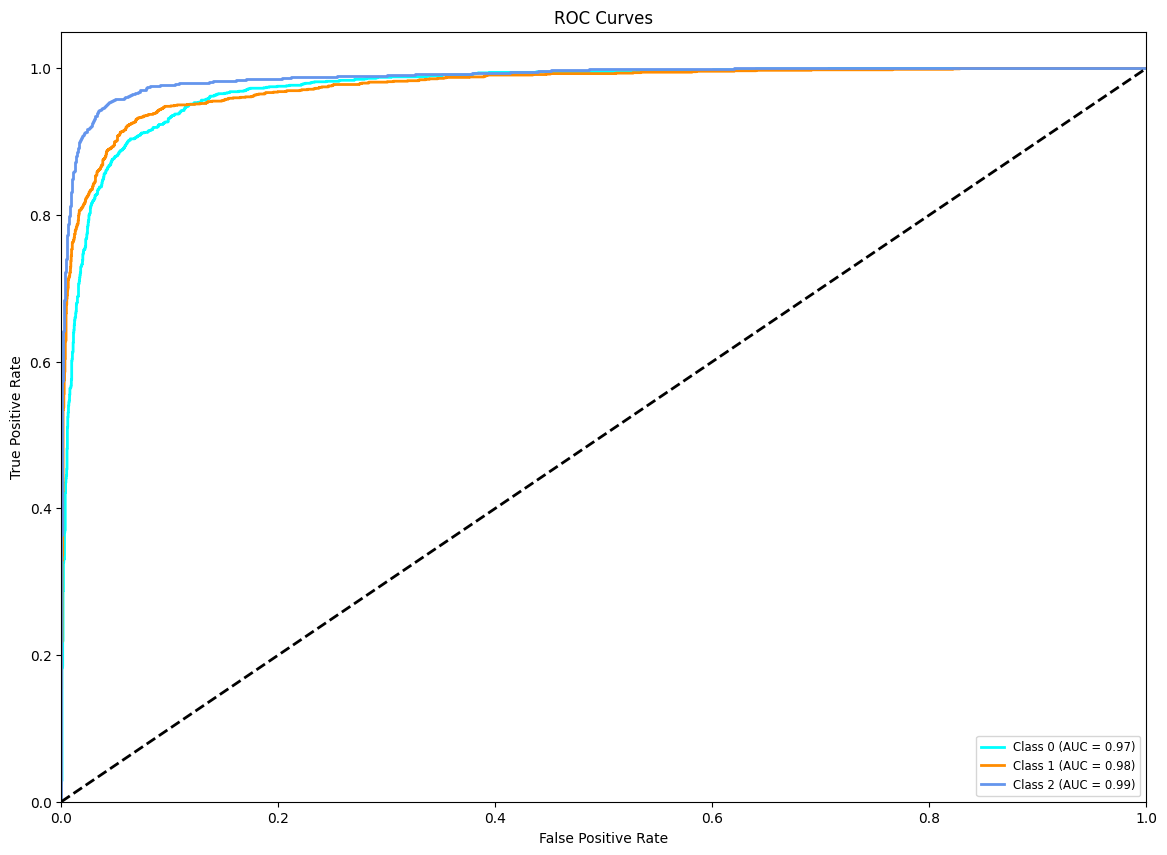

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.preprocessing import label_binarize

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

if len(all_labels.shape) == 1 or all_labels.shape[1] != 3:
    all_labels = label_binarize(all_labels, classes=range(3))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(14, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'yellow', 'purple', 'pink', 'brown'])

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right", fontsize='small')
plt.show()


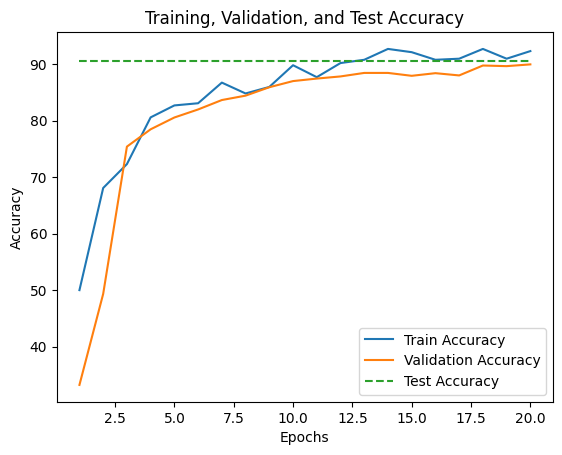

In [34]:
plt.figure()
epochs_range = range(1, len(train_accuracies) + 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, [test_accuracies[-1]] * len(epochs_range), label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


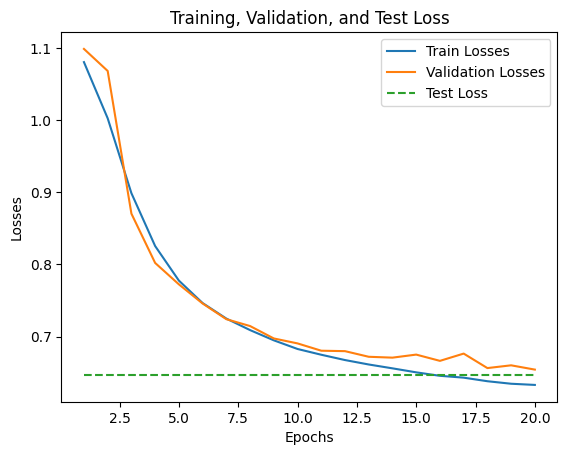

In [35]:
plt.figure()
epochs_range = range(1, len(train_accuracies) + 1)
plt.plot(epochs_range, train_losses, label='Train Losses')
plt.plot(epochs_range, validation_losses, label='Validation Losses')
plt.plot(epochs_range, [test_losses[-1]] * len(epochs_range), label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()